In [1]:
%matplotlib inline
import numpy as np
import os
import matplotlib.pyplot as plt
from ipywidgets import interact, fixed

In [126]:
def __p(phi):
    return phi*phi*phi*(10-15*phi+6*phi*phi)

def __g(phi):
    return (phi*phi*(1-phi)*(1-phi))

def __gprime(phi):
    return (4*phi*phi*phi - 6*phi*phi +2*phi)

_p = np.vectorize(__p)
_g = np.vectorize(__g) 
_gprime = np.vectorize(__gprime)

def grad(phi, dx, i):
    phim = np.roll(phi, -1, 0)
    phip = np.roll(phi, 1, 0)
    return (phip-phim)/(2*dx)

def grad2(phi, dx):
    phim = np.roll(phi, -1, 0)
    phip = np.roll(phi, 1, 0)
    return (phip+phim-2*phi)/(dx*dx)

def renormalize(q1, q2, q3, q4):
    q = np.sqrt(q1*q1+q2*q2+q3*q3+q4*q4)
    return q1/q, q2/q, q3/q, q4/q

In [127]:
#material parameters
T_mA = 1728. #melting point of nickel
T_mB = 1358. #melting point of copper
L_A = 2350. #latent heat of nickel, J/cm^3
L_B = 1728. #latent heat of copper, J/cm^3
s_A = 3.7e-5 #surface energy of nickel, J/cm^2
s_B = 2.9e-5 #surface energy of copper, J/cm^2
D_L = 1e-5 #diffusion in liquid, cm^2/s
D_S = 1e-9 #diffusion in solid, cm^2/s
B_A = 0.33 #linear kinetic coefficient of nickel, cm/K/s
B_B = 0.39 #linear kinetic coefficient of copper, cm/K/s
v_m = 7.42 #molar volume, cm^3/mol
R = 8.314 #gas constant, J/mol*K
y_e = 0.06 #anisotropy

In [189]:
np.set_printoptions(threshold=np.inf)
T = 1370.
res = 51
dx = 4.6e-6 #spacial division, cm
dx = 1.31e-6
dt = dx*dx/5./D_L
dt = 1.31e-9
print(dt)
d = dx/0.94 #interfacial thickness
ebar = np.sqrt(6*np.sqrt(2)*s_A*d/T_mA) #baseline energy

W_A = 3*s_A/(np.sqrt(2)*T_mA*d)
W_B = 3*s_B/(np.sqrt(2)*T_mB*d)
M_A = T_mA*T_mA*B_A/(6*np.sqrt(2)*L_A*d)
M_B = T_mB*T_mB*B_B/(6*np.sqrt(2)*L_B*d)
ebar = np.sqrt(6*np.sqrt(2)*s_A*d/T_mA)
print(W_A)

c = np.zeros(res)
phi = np.zeros(res)
q1 = np.zeros(res)
q2 = np.zeros(res)
q3 = np.zeros(res)
q4 = np.zeros(res)
c += 0.40831
#c += 0.001*np.random.rand(res, res)
phi += 1
phi[0] = 0
phi[res-1] = 0
diamondParam = 15
for i in range(res):
    q1[i] = (0.3*i+0.5)/(res-1)
    q2[i] = (0.3*(res-i-1)+0.5)/(res-1)

reference = np.zeros(res)
for i in range(res):
    reference[i] = i
if not os.path.isdir('data'):
    os.makedirs('data')

1.31e-09
0.0325927346396


In [190]:
#T = 1574
for i in range(20000):
    #print(i)
    g = _g(phi)
    p = _p(phi)
    gprime = _gprime(phi)
    H_A = W_A*gprime + 30*L_A*(1/T-1/T_mA)*g
    H_B = W_B*gprime + 30*L_B*(1/T-1/T_mB)*g
    phixx = grad2(phi, dx)
    lphi = phixx
    phix = grad(phi, dx, i)
    gq1 = grad(q1, dx, i)
    gq2 = grad(q2, dx, i)
    gq3 = grad(q3, dx, i)
    gq4 = grad(q4, dx, i)
    #print(gq1)
    smallest = 1e7
    for i in range(res):
        if(np.absolute(gq1[i]) < smallest):
            gq1[i] = smallest*np.sign(gq1[i])
        if(np.absolute(gq2[i]) < smallest):
            gq2[i] = smallest*np.sign(gq2[i])
        if(np.absolute(gq3[i]) < smallest):
            gq3[i] = smallest*np.sign(gq3[i])
        if(np.absolute(gq4[i]) < smallest):
            gq4[i] = smallest*np.sign(gq4[i])
    lq1 = grad2(q1, dx)
    lq2 = grad2(q2, dx)
    lq3 = grad2(q3, dx)
    lq4 = grad2(q4, dx)
    
    gqs = gq1*gq1+gq2*gq2+gq3*gq3+gq4*gq4
    rgqs = np.sqrt(gqs)
    gqs2 = gq1*lq1+gq2*lq2+gq3*lq3+gq4*lq4
    
    H = ebar*0.00001 # surface energy term for quaternions
    #print(H_A)
    
    #change in c
    D_C = D_S+p*(D_L-D_S)
    temp = D_C*v_m*c*(1-c)*(H_B-H_A)/R
    deltac = D_C*(grad2(c, dx))+(grad(D_C, dx, i)*grad(c, dx, i))+temp*(lphi)+(grad(temp, dx, i)*phix)
    #print(deltac)
    #print(temp)
    
    #change in phi
    M_phi = 1.*((1-c)*M_A + c*M_B)
    deltaphi = M_phi*(ebar*ebar*lphi-(1-c)*H_A-c*H_B+60*H*T*g*rgqs)
    #randArray = 2*np.random.rand(res)-1
    #alpha = 0.3
    #deltaphi += M_phi*alpha*randArray*(16*g)*((1-c)*H_A+c*H_B)
    
    #changes in q
    p2 = 1-p
    M_q = 8000000000*p
    gp2r = grad(p2, dx, i)/rgqs
    p2r3 = p2/(rgqs*gqs)
    t1 = H*T*(gp2r*gq1+p2r3*(lq1*gqs - gq1*gqs2))
    t2 = H*T*(gp2r*gq2+p2r3*(lq2*gqs - gq2*gqs2))
    t3 = H*T*(gp2r*gq3+p2r3*(lq3*gqs - gq3*gqs2))
    t4 = H*T*(gp2r*gq4+p2r3*(lq4*gqs - gq4*gqs2))
    second = q1*t1+q2*t2+q3*t3+q4*t4
    deltaq1 = M_q*(t1-q1*second+5e-14*lq1)
    deltaq2 = M_q*(t2-q2*second+5e-14*lq2)
    deltaq3 = M_q*(t3-q3*second+5e-14*lq3)
    deltaq4 = M_q*(t4-q4*second+5e-14*lq4)
    
    #apply changes
    deltaphi[0] = 0
    deltac[0] = 0
    deltaq1[0] = 0
    deltaq2[0] = 0
    deltaq3[0] = 0
    deltaq4[0] = 0
    deltaphi[res-1] = 0
    deltac[res-1] = 0
    deltaq1[res-1] = 0
    deltaq2[res-1] = 0
    deltaq3[res-1] = 0
    deltaq4[res-1] = 0
    #print(c)
    #print(phi)
    #print(q1)
    #print(q2)
    #print(q3)
    #print(q4)
    #print(gqs)
    #print("gp2r:", gp2r)
    #print("Second: ", second)
    #print("t4:", t4)
    
    ctemp = c.copy()
    c += deltac*dt
    phi += deltaphi*dt
    q1 += deltaq1*dt
    q2 += deltaq2*dt
    q3 += deltaq3*dt
    q4 += deltaq4*dt
    q1, q2, q3, q4 = renormalize(q1, q2, q3, q4)

#print(c)
#print(phi)
#print(q1)
#print(q2)
#print(q3)
#print(q4)    
print("Done!")

Done!


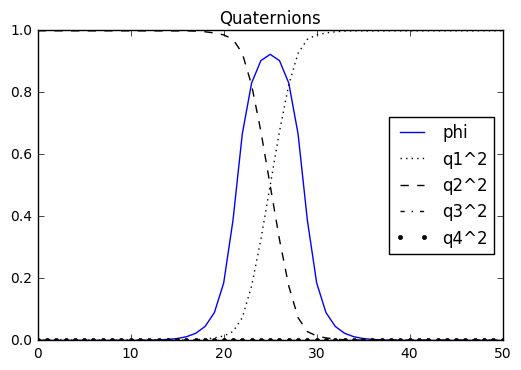

In [193]:
plt.rcParams['figure.figsize'] = 6, 4
plt.title('Quaternions')
plt.plot(reference,phi, 'b')
plt.plot(reference,q1*q1,'k:')
plt.plot(reference,q2*q2,'k--')
plt.plot(reference,q3*q3,'k-.')
plt.plot(reference,q4*q4,'k.')
plt.legend(['phi', 'q1^2', 'q2^2', 'q3^2', 'q4^2'], loc=5)
plt.savefig('graph.png')